In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import string
from pycocotools.coco import COCO
from random import randrange
from PIL import Image

In [2]:
class Vocab:
    def __init__(self,annFile,num_words=10000):
        self.vocab = self.build_vocab(annFile,num_words)
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
    
    def build_vocab(self,annFile, num_words=10000):
        # count up the number of words
        counts = {}
        coco = COCO(annFile)
        ids = coco.imgs.keys()
        for img_id in ids:
            ann_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(ann_ids)
            captions = self.simple_tokenize([ann['caption'] for ann in anns])
            for txt in captions:
                for w in txt:
                    counts[w] = counts.get(w, 0) + 1
        cw = sorted([(count, w) for w, count in counts.items()], reverse=True)

        vocab = [w for (_, w) in cw[:num_words]]
        vocab = ['PAD'] + vocab + ['UNK','EOS']

        return vocab
    
    def simple_tokenize(self,captions):
        processed = []
        for j, s in enumerate(captions):
            txt = str(s).lower().translate(None,string.punctuation).strip().split()
            processed.append(txt)
        return processed
    
    def get_caption(self,captions):
        unk = self.word2idx['UNK']
        eos = self.word2idx['EOS']
        captions = self.simple_tokenize(captions)
        caption = captions[randrange(len(captions))]
        
        targets = []
        for w in caption:
            targets.append(self.word2idx.get(w, unk))
        targets.append(eos)
        return torch.Tensor(targets) 
    
    def ids2caption(self,ids):
        words = []
        for id in ids:
            word = self.vocab[id.data[0,0]]
            words.append(word)
            if word == 'EOS':
                break
        caption = ' '.join(words)
        return caption

In [3]:
vc = Vocab("captions_train2014.json")

loading annotations into memory...
Done (t=2.02s)
creating index...
index created!


In [4]:
img_transform = transforms.Compose([
            transforms.Scale(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

data = dset.CocoCaptions(root='./train2014/',
                         annFile='captions_train2014.json',
                         transform=img_transform,
                         target_transform=vc.get_caption)

loading annotations into memory...
Done (t=1.92s)
creating index...
index created!


In [5]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    
    # Merge images (convert tuple of 3D tensor to 4D tensor)
    images = torch.stack(images, 0)
    
    # Merget captions (convert tuple of 1D tensor to 2D tensor)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap        
    return images, targets, lengths

In [6]:
data_iterator = torch.utils.data.DataLoader(data,batch_size=64,collate_fn=collate_fn,shuffle=True)

In [7]:
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.models as models

In [8]:
class CaptionModel(nn.Module):
    def __init__(self,vocab,
                 embedding_size=256,
                 hidden_size=512,
                 num_layers=2):
        super(CaptionModel, self).__init__()
        self.vocab = vocab
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cnn = models.resnet152(pretrained=True)
        
        for param in self.cnn.parameters():
            param.requires_grad = False
        
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_size, len(vocab))
        self.embedder = nn.Embedding(len(self.vocab), embedding_size)
    
    def forward(self, imgs, captions,lengths):
        embeddings = self.embedder(captions)

        img_features = self.cnn(imgs).unsqueeze(1)
        embeddings = torch.cat([img_features,embeddings], 1)
        packed_embeddings = pack_padded_sequence(embeddings,lengths,True)
        hiddens,_ = self.rnn(packed_embeddings)
        outputs = self.classifier(hiddens[0])

        return outputs
    
    def sample(self,img):
        img_transform = transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
        
        img = img_transform(img).unsqueeze(0)
        img = Variable(img).cuda()
        inputs = self.cnn(img).unsqueeze(0)
        
        sampled_ids = []
        state = (Variable(torch.zeros(self.num_layers, 1, self.hidden_size)).cuda(),
                 Variable(torch.zeros(self.num_layers, 1, self.hidden_size)).cuda())
        
        for i in range(20):
            hidden, state = self.rnn(inputs, state)                  # (1, 1, hidden_size)
            output = self.classifier(hidden.view(-1, self.hidden_size))  # (1, vocab_size)
            predicted = output.max(1)[1]
            sampled_ids.append(predicted)
            inputs = self.embedder(predicted)
            
        return sampled_ids

In [187]:
model = CaptionModel(vc.vocab).cuda()
criterion = nn.CrossEntropyLoss()

In [188]:
params = list(model.cnn.fc.parameters()) + list(model.rnn.parameters()) + list(model.classifier.parameters()) + list(model.embedder.parameters())
optimizer = torch.optim.Adam(params=params)

In [287]:
num_epochs = 3
for epoch in range(num_epochs):
    print "epochs:%s" % epoch
    
    for i, (images, captions, lengths) in enumerate(data_iterator):
        images = Variable(images).cuda()
        captions = Variable(captions).cuda()
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        preds = model(images,captions,lengths)
        loss = criterion(preds,targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print "iter:%s , loss:%s" % (i , loss.data[0])

epochs:0
iter:0 , loss:3.43946242332
iter:100 , loss:3.30441403389
iter:200 , loss:3.39198827744
iter:300 , loss:3.40326547623
iter:400 , loss:3.15766811371
iter:500 , loss:3.12730693817
iter:600 , loss:3.2153813839
iter:700 , loss:3.11062932014
iter:800 , loss:3.06269526482
iter:900 , loss:2.89941763878
iter:1000 , loss:2.95269846916
iter:1100 , loss:3.08243083954
iter:1200 , loss:3.21687650681
epochs:1
iter:0 , loss:3.05072855949
iter:100 , loss:2.78861069679
iter:200 , loss:2.86958789825
iter:300 , loss:2.809227705
iter:400 , loss:3.06551980972
iter:500 , loss:2.80777359009
iter:600 , loss:2.84343147278
iter:700 , loss:2.62977933884
iter:800 , loss:2.89996242523
iter:900 , loss:2.79492092133
iter:1000 , loss:2.82996082306
iter:1100 , loss:2.63608765602
iter:1200 , loss:2.9072291851
epochs:2
iter:0 , loss:2.54889130592
iter:100 , loss:2.60418224335
iter:200 , loss:2.76357388496
iter:300 , loss:2.80861592293
iter:400 , loss:2.97615551949
iter:500 , loss:2.60458803177
iter:600 , loss:2

In [292]:
torch.save(model.state_dict(),"caption_model.pkl")

In [288]:
images = os.listdir('./train2014/')
image_path = './train2014/' + images[0] 
img = Image.open(image_path)

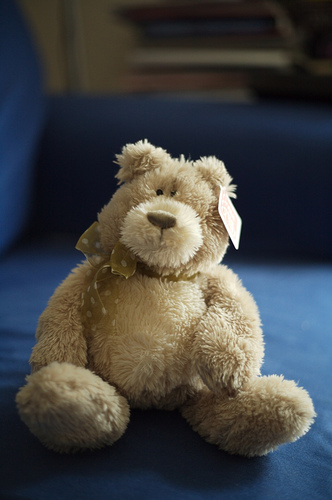

In [289]:
img

In [290]:
model.eval()
ids = model.sample(img)

In [291]:
vc.ids2caption(ids)

'a teddy bear sitting on top of a bed EOS'